# Parallelization

## Notes on Parallelization in Turing.jl

`~` is only thread safe for observations not assumptions: https://github.com/TuringLang/Turing.jl/blob/master/HISTORY.md

This makes sampling from the prior a bit difficult, since we need to fill the observation with an assumption.
However, the following macro can be used to disable threading depending on a condition. Usage:

```julia
@maybethreads <condition> for ...
```

## Install multi-threaded kernel

```julia
using Pkg
Pkg.activate("")
using IJulia
IJulia.installkernel("Julia 6 Threads", env=Dict(
    "JULIA_NUM_THREADS" => "6",
))
```

In [1]:
using Base.Threads
macro maybethreads(cond, ex)
    return esc(:($cond ? (@threads $ex) : $ex))
end

@maybethreads (macro with 1 method)

In [2]:
@maybethreads true for i in 1:10
    print("$i ")
end
Threads.nthreads()

3 5 1 9 4 10 7 6 2 8 

6

# Setup Environment
## vscode
Using vscode with a custom kernel might result in the X11 DISPLAY variable not being found.
The easiest workaround is to start an external kernel, for example via `jupyter-server`.

## plotly with jupyter lab
If using Jupyter Lab, install the extension to use plotly.
```shell
conda install nodejs
jupyter labextension install jupyterlab-plotly
```

In [3]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using MCMCDepth
using GLAbstraction, GLFW, SciGL
# TODO How to avoid adding them (automatically install / use with SciGL.jl)
using LinearAlgebra, CoordinateTransformations, Rotations
using Images
using AbstractMCMC
using Soss, MeasureTheory
using TransformVariables
using BenchmarkTools, DataFrames, StatsPlots
plotly()

  Activating project at `~/code/mcmc-depth-images`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /home/rd/code/mcmc-depth-images/Manifest.toml:0
┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/rd/.julia/packages/Plots/FI0vT/src/backends.jl:432


Plots.PlotlyBackend()

# Initialize the **OpenGL** offscreen render context


In [4]:
const WIDTH = 150
const HEIGHT = 150
# Create the GLFW window. This sets all the hints and makes the context current.
window = context_offscreen(WIDTH, HEIGHT)
# Buffer
framebuffer = depth_framebuffer(WIDTH, HEIGHT)
enable_depth_stencil()
set_clear_color()
# Shader Program
depth_prog = GLAbstraction.Program(SimpleVert, DepthFrag);

Load the the camera and mesh. Wrap them in a scene for simplified rendering.


In [5]:
camera = CvCamera(WIDTH, HEIGHT, 1.2 * WIDTH, 1.2 * HEIGHT, WIDTH / 2, HEIGHT / 2) |> SceneObject
monkey = load_mesh(depth_prog, "meshes/monkey.obj") |> SceneObject
cube = load_mesh(depth_prog, "meshes/cube.obj") |> SceneObject
scene = Scene(camera, [monkey]);
cube_scene = Scene(camera, [monkey, cube]);

In [6]:
function render_depth(scene::Scene)
    GLAbstraction.bind(framebuffer)
    clear_buffers()
    draw(depth_prog, scene)
    # load float values
    img = channelview(gpu_data(framebuffer, 1))
    transpose(img[:,end:-1:1])
end;

# Render the nominal scene
This is the scene without any noise in the pose or sensor.

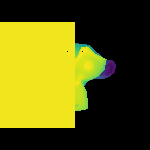

In [7]:
t = [0, 0, 2.0]
cov_t = [0.1 0 0; 0 0.1 0; 0 0 0.1]
σ_t = [0.1, 0.1, 0.1]
r = [0, π, 0]
monkey.pose.t = Translation(t)
monkey.pose.R = RotZYX(r...)
cube.pose.t = Translation(t + [0.5, 0, 0.2])
camera.pose.R = lookat(camera, monkey, [0, 1, 0]);
nominal_depth = render_depth(cube_scene)
colorize_depth(nominal_depth)

# Probabilistic Model


Soss expects a symbol on the left side -> workaround is to encapsulate everything in one function. This also cleans up the code.


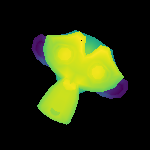

In [8]:
function render_pose_depth(scene, t, r)
    scene.meshes[1].pose.t = Translation(t)
    scene.meshes[1].pose.R = RotZYX(r...)
    render_depth(scene)
end
pose_depth = render_pose_depth(scene, t + [0, 0, -0.5], r + [0.5, 0, 0])
colorize_depth(pose_depth)

Describes how the data is generated given:

- A `scene` with all relevant object, the first object is assumed to be the object of interest
- The RFID measurement for the position with the mean and covariance `mean_t` & `cov_t`
- The model will be conditioned on the depth image `y`


In [9]:
# TODO  must be handled by preprocessing
const MAX_DEPTH = 2.0
const PIXEL_σ = 0.01
# θ=1/λ
const PIXEL_θ = 1 / 0.5
const ZERO_IMG = zeros(WIDTH, HEIGHT);

## Prior Model

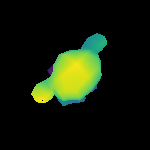

In [10]:
prior_model = @model mean_t, σ_t begin
    # TODO MvNormal does not support xform?
    # t ~ MvNormal(mean_t, σ_t)
    # Sample position from RFID position
    t .~ Normal.(mean_t, σ_t)
    # We don't know anything about the orientation or the occlusion
    r ~ For(1:3) do _
        CircularUniform()
    end
    o .~ UniformInterval.(ZERO_IMG, 1)
    b = 2 * o
end
θ1 = rand(prior_model(mean_t = t, σ_t = σ_t))
μ1 = render_pose_depth(scene, θ1.t, θ1.r)
colorize_depth(μ1)

## Observation Model
The old model requires to sample a realiziation of the occlusion and thus randomly evaluates the exponential or normal distribution.
The  new model uses a `Mixture` which marginalizes `o` analytically.

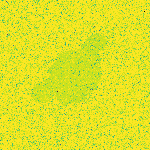

In [11]:
old_observation_model = @model μ, o begin
    # Sensor model
    occluded .~ MeasureTheory.Bernoulli.(o)
    obs ~ For(eachindex(μ)) do i
        if occluded[i]
            Exponential(PIXEL_θ)
        else
            Normal(μ[i], PIXEL_σ)
        end
    end
end
colorize_depth(rand(old_observation_model(μ = μ1, o = θ1.o)).obs)

## Analytic pixel association
An analytic solution for the probability of a pixel belonging to the object or not.
* logarithmic formulation is much slower, due to `logaddexp` and the requirement to calculate the non-lograthmic probability, which would require another application of `exp`
* Exponential might make more

In [76]:
using LogExpFunctions

function pixel_association(μ, z, prior_is)
    prior_not = 1 .- prior_is
    # TODO pdf much more expensive than logdensity
    p_is = pdf.(Normal.(μ, PIXEL_σ), z)
    # TODO occlusion or uniform better?
    p_not = pdf.(Exponential.(fill(PIXEL_θ, size(μ))), z)
    # Equivalent to p_not = exp.(logdensity.(UniformInterval.(zeros(size(nominal_depth)), MAX_DEPTH), z))
    # p_not = fill(1 / MAX_DEPTH, size(μ))
    numerator = p_is .* prior_is
    marginal = numerator + (p_not .* prior_not)
    numerator ./ marginal
end

μ666 = render_pose_depth(scene, t, r)
prior_is = fill(0.1, size(μ666))
log_prior_is = log.(prior_is)
p_object = pixel_association(μ666, nominal_depth, prior_is)
colorize_depth(p_object)
minimum(p_object)
# TODO can/should we still ignore the invalid pixel of the rendering?

0.0

In [66]:
@benchmark pixel_association(μ666, nominal_depth, prior_is)

BenchmarkTools.Trial: 727 samples with 1 evaluation.
 Range (min … max):  4.961 ms … 24.674 ms  ┊ GC (min … max): 0.00% … 64.04%
 Time  (median):     6.307 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.861 ms ±  2.879 ms  ┊ GC (mean ± σ):  6.87% ± 11.88%

   █▅▁▄▃▁                                                     
  ▆██████▇▆▅▄▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▁▂ ▃
  4.96 ms        Histogram: frequency by time        22.8 ms <

 Memory estimate: 4.46 MiB, allocs estimate: 157530.

In [41]:
@benchmark pixel_association_log(μ666, nominal_depth, log_prior_is)

BenchmarkTools.Trial: 2479 samples with 1 evaluation.
 Range (min … max):  1.480 ms … 16.700 ms  ┊ GC (min … max):  0.00% … 83.84%
 Time  (median):     1.653 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   2.009 ms ±  1.580 ms  ┊ GC (mean ± σ):  12.78% ± 13.63%

  █▇▄▃▂▃▂▁                                                    
  █████████▇▆▃▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▆▆▄▅▅▆▆ █
  1.48 ms      Histogram: log(frequency) by time     11.2 ms <

 Memory estimate: 3.61 MiB, allocs estimate: 45034.

In [34]:
observation_model = @model μ, o begin
    obs ~ For(eachindex(μ)) do i
        # TODO not accepting new samples?
        # TODO actually marginalizing analytically?
        
        # TODO avoid evaluating the same logdensity twice
        BinaryMixture(Normal(μ[i], PIXEL_σ), UniformInterval(0.0, MAX_DEPTH), o[i], 1.0 - o[i])
        #Normal(μ[i], PIXEL_σ)
    end
end;
colorize_depth(rand(observation_model(μ = μ1, o = θ1.o)).obs)

LoadError: DomainError with -0.47495825841288153:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [16]:
# @license BSD-3 https://opensource.org/licenses/BSD-3-Clause
# Copyright (c) 2022, Institute of Automatic Control - RWTH Aachen University
# All rights reserved. 
logdensity(Dirac(2.0), 2.0)

0.0

Performance: Only evaluate the pixels which are nonzero in the rendered image.
All the zero pixels don't contribute to the likelihood and thus have the same likelihood: 1.

Handle invalid values ∉[0,MAX_DEPTH]. Our convention for invalid values is to set them to zero.

In [35]:
function preprocess(render, obs...)
    # Use only the nonzero values of the render for the likelihood
    indices = findall(!iszero, render)
    render_select = render[indices]
    results = []
    for o in obs
        select = o[indices]
        # Convention for invalid values: depth=0
        limit = [ifelse(0 <= x <= MAX_DEPTH, x, zero(x)) for x in select]
        push!(results, limit)
    end   
    render_select, results...
end;

In [36]:
μ1_prep, obs_prep, o_prep = preprocess(μ1, nominal_depth, θ1.o)
colorize_depth(μ1_prep)

In [37]:
colorize_depth(obs_prep)

In [38]:
colorize_depth(o_prep)

## Proposal Model
### Prior Proposals
Draws a random sample from the prior distribution. Results in a worse acceptance rate, if the posterior is focused on a small parameter space.

### Gaussian Proposals
Propose a new sample from the old sample `s` by sampling using a normal distribution centered around the value of the old parameter.
Might lead to a higher acceptance rate for focused posteriors.
If the parameters are bounded, e.g. $\lambda$ of a Poisson distribution, this library takes care it by transforming variables to the space of all real numbers and back to the constrained space.

In [39]:
const PROPOSAL_σ_t = [0.01, 0.01, 0.01]
const PROPOSAL_σ_r = [0.1, 0.1, 0.1]
const PROPOSAL_σ_o = fill(0.5, WIDTH, HEIGHT);

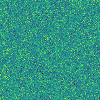

In [40]:
proposal_model = @model dummy_t begin
    # Sample position from RFID position
    t .~ Normal.(dummy_t, PROPOSAL_σ_t)
    # We don't know anything about the orientation or the occlusion
    r .~ Normal.(0, PROPOSAL_σ_r)
    o .~ Normal.(0, PROPOSAL_σ_o)
end;
# TODO args change the order, this workaround is quite hacky
prop = rand(proposal_model(dummy_t=0.0))
colorize_depth(prop.o)

# Posterior Model
Wrap the prior and the observation model in a `PosteriorModel`

The obeservation model is a bit more elaborate to evaluate, since the expected observation has to be rendered and

In [41]:
struct DepthModel
    model
    obs
end
function MeasureTheory.logdensity(dm::DepthModel, sample::Sample)
    θ = state(sample)
    μ = render_pose_depth(scene, θ.t, θ.r)
    μ_prep, obs_prep, o_prep = preprocess(μ, dm.obs, θ.o)
    logdensity(dm.model(μ = μ_prep, o = o_prep) | (; obs = obs_prep))
end

In [42]:
# using Random, TransformVariables
depth_posterior_model = PosteriorModel(prior_model(mean_t = t, σ_t = σ_t), DepthModel(observation_model, nominal_depth))
# TODO somehow not providing the empty args modifies the order of the sampled variables
depth_mh = MetropolisHastings(SymmetricProposal(proposal_model(dummy_t=0.0)))

samples = sample(depth_posterior_model, depth_mh, MCMCThreads(), 1000, 20, progress = true);

In [43]:
flattened_samples = MCMCDepth.flatten(samples)
translations = map(x -> state(x).t, flattened_samples[begin:100:end]);
translations_matrix = reduce(hcat, translations)

3×200 Matrix{Float64}:
 0.0281983  0.0281983  0.0281983  …  -0.0794485  -0.0794485  -0.0794485
 0.160692   0.160692   0.160692      -0.0653058  -0.0653058  -0.0653058
 1.93605    1.93605    1.93605        2.03579     2.03579     2.03579

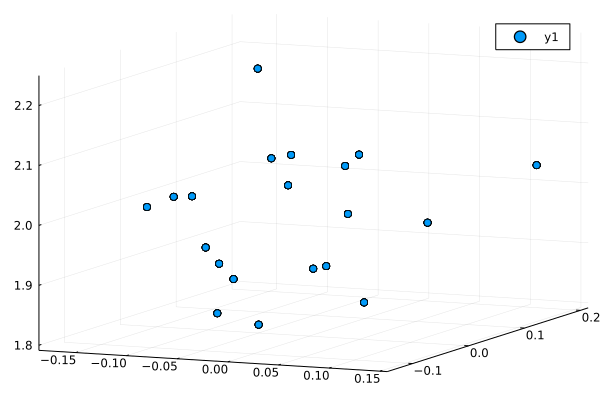

In [44]:
#gr()
scatter(translations_matrix[1,:], translations_matrix[2,:], translations_matrix[3,:])

# Evaluation

In [30]:
function sample_chain(;num_samples = 1_000, use_threads=true)
    chain = [propose_prior(mh)]
    lk = SpinLock()
    @maybethreads use_threads for _ in 2:num_samples
        lock(lk)
        try
            new_sample = last(chain)
        finally
            unlock(lk)
        end
        # worse mixing than normal
        # new_sample = propose_prior(mh)
        new_sample = mh_symmetric_kernel(last(chain), new_sample)
        lock(lk)
        try
            push!(chain, new_sample)
        finally
            unlock(lk)
        end
    end
    chain
end;

In [31]:
chain = sample_chain(num_samples = 20_000, use_threads=true)

LoadError: UndefVarError: propose_prior not defined

# Plots
A sample is a tuple of the log-likelihood and the vales. Therefore, create a new dataframe, which has the likelihood in the same row as the samples value.

In [32]:
df_c = DataFrame(chain)
df = DataFrame(df_c.val)
df[!,:ℓ] = df_c.ℓ;

LoadError: UndefVarError: chain not defined

In [ ]:
t_samples = hcat(df.t...)'
l1 = plot(t_samples[:,1], title="t[1] samples")
d1 = StatsPlots.density(t_samples[:,1], title="t[1] density")
l2 = plot(t_samples[:,2], title="t[2] samples")
d2 = StatsPlots.density(t_samples[:,2], title="t[2] density")
l3 = plot(t_samples[:,3], title="t[3] samples")
d3 = StatsPlots.density(t_samples[:,3], title="t[3] density")
plot(l1, d1, l2, d2, l3, d3, layout=(3,2), legend=false)

In [ ]:
r_samples = hcat(df.r...)'
l1 = plot(r_samples[:,1], title="r[1] samples")
d1 = StatsPlots.density(r_samples[:,1], title="r[1] density")
l2 = plot(r_samples[:,2], title="r[2] samples")
d2 = StatsPlots.density(r_samples[:,2], title="r[2] density")
l3 = plot(r_samples[:,3], title="r[3] samples")
d3 = StatsPlots.density(r_samples[:,3], title="r[3] density")
plot(l1, d1, l2, d2, l3, d3, layout=(3,2), legend=false)

In [ ]:
colorview(Gray, mean(df.occ_prob))

# Benchmark observation models
- The new model requires some preprocessing but the logdensity can be calculated analytically without extra sampling
- `logsumpexp` seems very expensive, thus use the `BinaryMixture` if possible, which uses `logaddexp`.

In [18]:
old_observation_prior = prior(old_observation_model, :obs)
@benchmark begin
    μ1_prep, obs_prep, o_prep = preprocess(μ1, nominal_depth, θ1.o)
    occluded_old = rand(old_observation_prior(μ = μ1_prep, o = o_prep)).occluded
    logdensity(old_observation_model(μ = μ1_prep, o = o_prep) | (; occluded = occluded_old, obs = nominal_depth))
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  146.433 μs …   4.713 ms  ┊ GC (min … max): 0.00% … 95.01%
 Time  (median):     149.747 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   163.930 μs ± 165.163 μs  ┊ GC (mean ± σ):  4.03% ±  3.88%

  ▂██▆▅▃▁▂▃▁                        ▁▃▂▃▂▂▂▁▁                   ▂
  █████████████▇▇▇▇▇▇▇▆▆▆▇▆▅▆▆▇█▇▇▆▇███████████▇▅▆▆▅▁▅▆▆▅▆▄▆▆▄▆ █
  146 μs        Histogram: log(frequency) by time        227 μs <

 Memory estimate: 193.00 KiB, allocs estimate: 1063.

In [19]:
@benchmark begin
    μ1_prep, obs_prep, o_prep = preprocess(μ1, nominal_depth, θ1.o)
    logdensity(observation_model(μ = μ1_prep, o = o_prep) | (; obs = obs_prep))
end

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  118.606 μs …  3.618 ms  ┊ GC (min … max): 0.00% … 92.02%
 Time  (median):     138.910 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   144.553 μs ± 99.344 μs  ┊ GC (mean ± σ):  1.98% ±  2.79%

   ▁        █ ▁▁                                                
  ▂█▃▂▁▂▃▄▆▄█▆██▃▇▅▃▅▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  119 μs          Histogram: frequency by time          215 μs <

 Memory estimate: 106.69 KiB, allocs estimate: 32.

# Benchmark Broadcasting vs Loop


In [ ]:
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
@benchmark sample_chain(num_samples = 5_000, use_threads=false)

In [ ]:
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
@benchmark sample_chain(num_samples = 5_000, use_threads=true)

# Scratchpad

In [ ]:
simple_depth_model = @model scene, mean_t, cov_t begin
    # sensor model
    y .~ Normal.(μ[i], PIXEL_σ)
end;